In [30]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

## Read data file and some glimpse on raw data

In [31]:
filename = "data_LSTM.csv"
df = pd.read_csv(filename, header=0, sep=',', dtype=np.float64)
print('Are ther any Nan value?:\n', np.isnan(df).any())
# ignore rows which contain zero
# ignore rows which have negative instantaneous rate
ignore_zero = df[(df['Strain']==0) | (df['Stress']==0) | (df['Temp']==0) | (df['Rate']<=0) | (df['I_Temp']==0)]
df=pd.concat([df, ignore_zero, ignore_zero]).drop_duplicates(keep=False)
df=pd.concat([df, ignore_zero, ignore_zero]).drop_duplicates(keep=False)
df.head()

Are ther any Nan value?:
 Strain    False
Stress    False
delT      False
Rate      False
I_Temp    False
Temp      False
dtype: bool


,Strain,Stress,delT,Rate,I_Temp,Temp
1,0.00011,464.791757,0.0,0.0001,298.0,298.0
2,0.00020,578.992923,0.0,0.0001,298.0,298.0
3,0.00030,628.611219,0.0,0.0001,298.0,298.0
4,0.00040,653.174300,0.0,0.0001,298.0,298.0
5,0.00050,669.638434,0.0,0.0001,298.0,298.0


## Splitting flow curves

The individual flow curves are stacked one after the other in the csv file, so they need to be split according to the strain rate and temperature

In [32]:
# Flow curve in normal environment; room temperature/quasi-static loading
df_QSRT = df[(df['Temp']==298.0) & (df['Rate']==0.000278)]
df_QSRT.head()

,Strain,Stress,delT,Rate,I_Temp,Temp


In [33]:
# Flow curves in different temperatures at quasi-static loading
df_QSRT = df[(df['Temp']==298.0) & (df['Rate']==0.000278)]
df_373K = df[(df['Temp']==373.0) & (df['Rate']==0.000278)]
df_473K = df[(df['Temp']==473.0) & (df['Rate']==0.000278)]
df_573K = df[(df['Temp']==573.0) & (df['Rate']==0.000278)]
df_673K = df[(df['Temp']==673.0) & (df['Rate']==0.000278)]

In [34]:
# Flow curves in different strain rates at RT
df_e4 = df[(df['Rate']==0.0001) & (df['I_Temp']==298.0)]
df_QSRT = df[(df['Rate']==0.000278) & (df['Temp']==298.0)]
df_e3 = df[(df['Rate']==0.001) & (df['I_Temp']==298.0)]
df_e2 = df[(df['Rate']==0.01) & (df['Temp']!=298.0) & (df['Temp']!=373.001) & (df['Temp']!=373.0) & (df['I_Temp']==298)]
df_e1 = df[(df['Rate']==0.1) & (df['Temp']!=298.0) & (df['I_Temp']==298)]

In [35]:
# Flow curves in 0.1 strain rate at varying T
df_e1_RT = df[(df['Rate']==0.1) & (df['I_Temp']==298.0)]
df_e1_373K = df[(df['Rate']==0.1) & (df['I_Temp']==373.0)]
df_e1_473K = df[(df['Rate']==0.1) & (df['I_Temp']==473.0)]
df_e1_573K = df[(df['Rate']==0.1) & (df['I_Temp']==573.0)]
df_e1_673K = df[(df['Rate']==0.1) & (df['I_Temp']==673.0)]

In [36]:
# Flow curves in 0.01 strain rate at varying T
df_e2_RT = df[(df['Rate']==0.01) & (df['I_Temp']==298.0)]
df_e2_373K = df[(df['Rate']==0.01) & (df['I_Temp']==373.0)]
df_e2_473K = df[(df['Rate']==0.01) & (df['I_Temp']==473.0)]
df_e2_573K = df[(df['Rate']==0.01) & (df['I_Temp']==573.0)]
df_e2_673K = df[(df['Rate']==0.01) & (df['I_Temp']==673.0)]

In [37]:
# Flow curves in 0.001 strain rate at varying T
df_e3_RT = df[(df['Rate']==0.001) & (df['I_Temp']==298.0)]
df_e3_373K = df[(df['Rate']==0.001) & (df['I_Temp']==373.0)]
df_e3_473K = df[(df['Rate']==0.001) & (df['I_Temp']==473.0)]
df_e3_573K = df[(df['Rate']==0.001) & (df['I_Temp']==573.0)]
df_e3_673K = df[(df['Rate']==0.001) & (df['I_Temp']==673.0)]

In [38]:
# Flow curves in 0.0001 strain rate at varying T
df_e4_RT = df[(df['Rate']==0.0001) & (df['I_Temp']==298.0)]
df_e4_373K = df[(df['Rate']==0.0001) & (df['I_Temp']==373.0)]
df_e4_473K = df[(df['Rate']==0.0001) & (df['I_Temp']==473.0)]
df_e4_573K = df[(df['Rate']==0.0001) & (df['I_Temp']==573.0)]
df_e4_673K = df[(df['Rate']==0.0001) & (df['I_Temp']==673.0)]

In [39]:
# Put all flow curves in a dictionary for easy access 
flows = {'e4': df_e4,
         'e4_373K': df_e4_373K,
         'e4_473K': df_e4_473K,
         'e4_573K': df_e4_573K,
         'e4_673K': df_e4_673K,
         'QSRT': df_QSRT,
         '373K': df_373K, 
         '473K': df_473K,
         '573K': df_573K,
         '673K': df_673K,
         'e3': df_e3,
         'e3_373K': df_e3_373K,
         'e3_473K': df_e3_473K,
         'e3_573K': df_e3_573K,
         'e3_673K': df_e3_673K,
         'e2': df_e2,
         'e2_373K': df_e2_373K,
         'e2_473K': df_e2_473K,
         'e2_573K': df_e2_573K,
         'e2_673K': df_e2_673K,
         'e1': df_e1,
         'e1_373K': df_e1_373K,
         'e1_473K': df_e1_473K,
         'e1_573K': df_e1_573K,
         'e1_673K': df_e1_673K
        }

## Plot all the flow curves

([<matplotlib.axis.YTick at 0x7f753cc14f10>,
 [Text(0, 150, '150'),
  Text(0, 250, '250'),
  Text(0, 350, '350'),
  Text(0, 450, '450')])

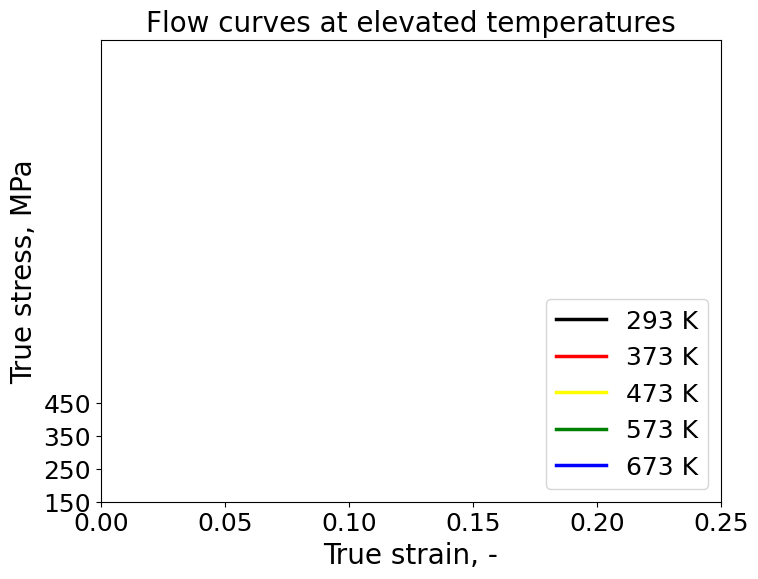

In [40]:
# Flow curves at QS loading, varying T
plt.figure(figsize=(8,6))
plt.plot(df_QSRT['Strain'], df_QSRT['Stress'], label='293 K', color='black', linewidth=2.5)
plt.plot(df_373K['Strain'], df_373K['Stress'], label='373 K', color='red',linewidth=2.5)
plt.plot(df_473K['Strain'], df_473K['Stress'], label='473 K', color='yellow',linewidth=2.5)
plt.plot(df_573K['Strain'], df_573K['Stress'], label='573 K', color='green',linewidth=2.5)
plt.plot(df_673K['Strain'], df_673K['Stress'], label='673 K', color='blue',linewidth=2.5)

plt.xlabel('True strain, -', fontsize='20')    #Name x label
plt.ylabel('True stress, MPa', fontsize='20')    #Name y label
plt.title('Flow curves at elevated temperatures', fontsize='20')    #Title name
plt.legend(loc=4, fontsize='18')
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=150, ymax=1550) # y-axis range
plt.xticks(fontsize='18')
plt.yticks(np.arange(150, 550, 100), fontsize='18')

([<matplotlib.axis.YTick at 0x7f753cc3e7d0>,
 [Text(0, 200, '200'),
  Text(0, 300, '300'),
  Text(0, 400, '400'),
  Text(0, 500, '500'),
  Text(0, 600, '600'),
  Text(0, 700, '700'),
  Text(0, 800, '800'),
  Text(0, 900, '900'),
  Text(0, 1000, '1000'),
  Text(0, 1100, '1100'),
  Text(0, 1200, '1200'),
  Text(0, 1300, '1300'),
  Text(0, 1400, '1400'),
  Text(0, 1500, '1500')])

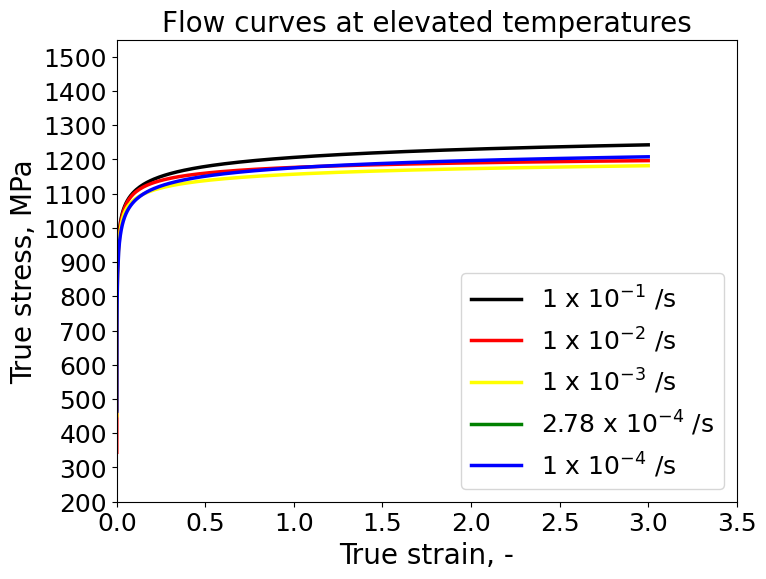

In [41]:
# Flow curves at varying strain rates at RT

plt.figure(figsize=(8,6))
plt.plot(df_e1_RT['Strain'], df_e1_RT['Stress'], label='1 x $10^{-1}$ /s', color='black',linewidth=2.5)
plt.plot(df_e2_RT['Strain'], df_e2_RT['Stress'], label='1 x $10^{-2}$ /s', color='red',linewidth=2.5)
plt.plot(df_e3_RT['Strain'], df_e3_RT['Stress'], label='1 x $10^{-3}$ /s', color='yellow',linewidth=2.5)
plt.plot(df_QSRT['Strain'], df_QSRT['Stress'], label='2.78 x $10^{-4}$ /s', color='green',linewidth=2.5)
plt.plot(df_e4_RT['Strain'], df_e4_RT['Stress'], label='1 x $10^{-4}$ /s', color='blue', linewidth=2.5)


plt.xlabel('True strain, -', fontsize='20')    #Name x label
plt.ylabel('True stress, MPa', fontsize='20')    #Name y label
plt.title('Flow curves at elevated temperatures', fontsize='20')    #Title name
plt.legend(loc=4, fontsize='18')
plt.xlim(xmin=0, xmax=3.5) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=200, ymax=1550) # y-axis range
plt.xticks(fontsize='18')
plt.yticks(np.arange(200, 1550, 100), fontsize='18')

(300.0, 1550.0)

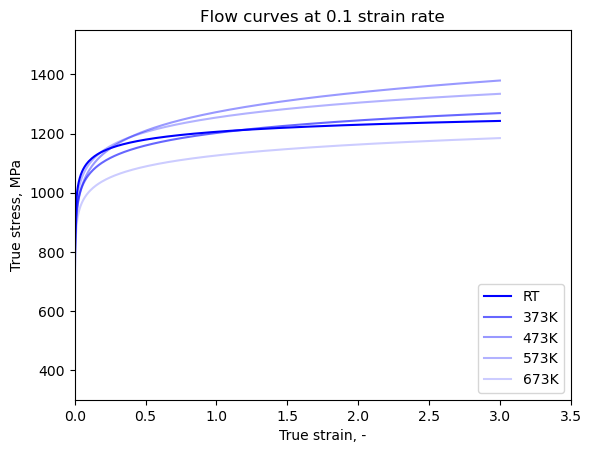

In [42]:
# 0.1 strain rate, all temperatures

plt.plot(df_e1_RT['Strain'], df_e1_RT['Stress'], label='RT', color='blue', alpha=1.0)
plt.plot(df_e1_373K['Strain'], df_e1_373K['Stress'], label='373K', color='blue', alpha=0.6)
plt.plot(df_e1_473K['Strain'], df_e1_473K['Stress'], label='473K', color='blue', alpha=0.4)
plt.plot(df_e1_573K['Strain'], df_e1_573K['Stress'], label='573K', color='blue', alpha=0.3)
plt.plot(df_e1_673K['Strain'], df_e1_673K['Stress'], label='673K', color='blue', alpha=0.2)

plt.xlabel('True strain, -')    #Name x label
plt.ylabel('True stress, MPa')    #Name y label
plt.title('Flow curves at 0.1 strain rate')    #Title name
plt.legend(loc=4)
plt.xlim(xmin=0, xmax=3.5) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=300, ymax=1550) # y-axis range

(300.0, 1550.0)

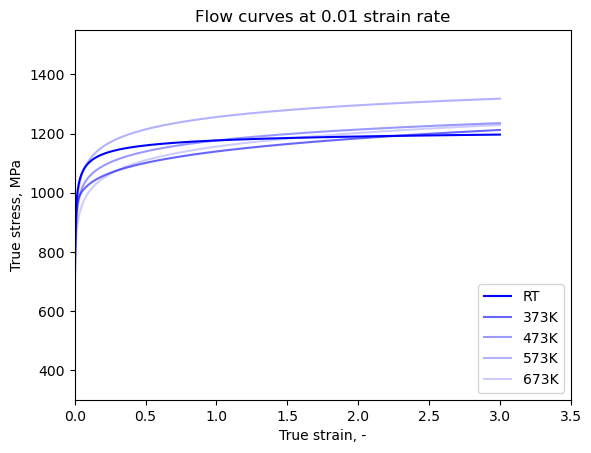

In [43]:
# 0.01 strain rate, all temperatures

plt.plot(df_e2_RT['Strain'], df_e2_RT['Stress'], label='RT', color='blue', alpha=1.0)
plt.plot(df_e2_373K['Strain'], df_e2_373K['Stress'], label='373K', color='blue', alpha=0.6)
plt.plot(df_e2_473K['Strain'], df_e2_473K['Stress'], label='473K', color='blue', alpha=0.4)
plt.plot(df_e2_573K['Strain'], df_e2_573K['Stress'], label='573K', color='blue', alpha=0.3)
plt.plot(df_e2_673K['Strain'], df_e2_673K['Stress'], label='673K', color='blue', alpha=0.2)

plt.xlabel('True strain, -')    #Name x label
plt.ylabel('True stress, MPa')    #Name y label
plt.title('Flow curves at 0.01 strain rate')    #Title name
plt.legend(loc=4)
plt.xlim(xmin=0, xmax=3.5) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=300, ymax=1550) # y-axis range

(300.0, 1550.0)

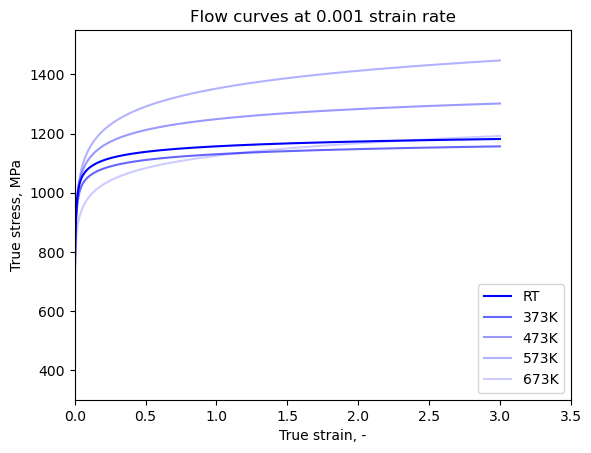

In [44]:
# 0.001 strain rate, all temperatures

plt.plot(df_e3_RT['Strain'], df_e3_RT['Stress'], label='RT', color='blue', alpha=1.0)
plt.plot(df_e3_373K['Strain'], df_e3_373K['Stress'], label='373K', color='blue', alpha=0.6)
plt.plot(df_e3_473K['Strain'], df_e3_473K['Stress'], label='473K', color='blue', alpha=0.4)
plt.plot(df_e3_573K['Strain'], df_e3_573K['Stress'], label='573K', color='blue', alpha=0.3)
plt.plot(df_e3_673K['Strain'], df_e3_673K['Stress'], label='673K', color='blue', alpha=0.2)

plt.xlabel('True strain, -')    #Name x label
plt.ylabel('True stress, MPa')    #Name y label
plt.title('Flow curves at 0.001 strain rate')    #Title name
plt.legend(loc=4)
plt.xlim(xmin=0, xmax=3.5) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=300, ymax=1550) # y-axis range

(300.0, 1550.0)

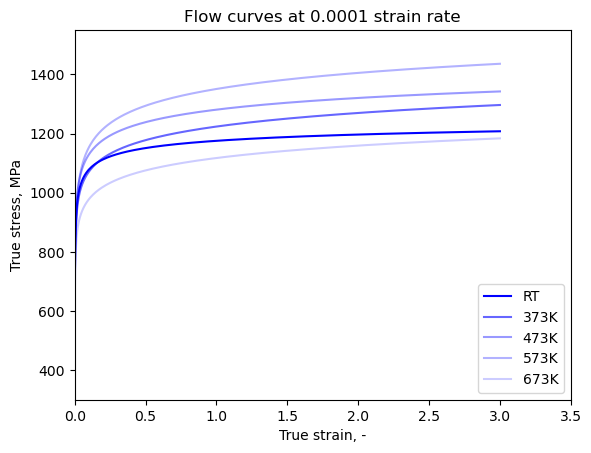

In [45]:
# 0.01 strain rate, all temperatures

plt.plot(df_e4_RT['Strain'], df_e4_RT['Stress'], label='RT', color='blue', alpha=1.0)
plt.plot(df_e4_373K['Strain'], df_e4_373K['Stress'], label='373K', color='blue', alpha=0.6)
plt.plot(df_e4_473K['Strain'], df_e4_473K['Stress'], label='473K', color='blue', alpha=0.4)
plt.plot(df_e4_573K['Strain'], df_e4_573K['Stress'], label='573K', color='blue', alpha=0.3)
plt.plot(df_e4_673K['Strain'], df_e4_673K['Stress'], label='673K', color='blue', alpha=0.2)

plt.xlabel('True strain, -')    #Name x label
plt.ylabel('True stress, MPa')    #Name y label
plt.title('Flow curves at 0.0001 strain rate')    #Title name
plt.legend(loc=4)
plt.xlim(xmin=0, xmax=3.5) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=300, ymax=1550) # y-axis range

## Preprocessing

In this section, the data is first normalised, then split into train-test data, and finally split into features and labels.

In [63]:
# First, logarithm is applied to strain and strain rate before normalising.

flows_log = {}
for key, fc in flows.items():
    fc = fc.reset_index(drop=True)
    # apply decadic log to strain rates
    log_rate = pd.DataFrame(np.log10(fc['Rate'].values))
    log_rate.columns = ['log_rate']
    # apply decadic log to strain
    log_strain = pd.DataFrame(np.log10(fc['Strain'].values))
    log_strain.columns = ['log_strain']
    
    fc_log = pd.concat([fc, log_strain, log_rate], axis=1)
    fc_log = fc_log.drop(columns=['Strain', 'Rate'])
    cols = ['log_strain', 'log_rate', 'I_Temp', 'Temp', 'Stress', 'delT']
    fc_log = fc_log[cols]
    flows_log[key] = fc_log
raw_features = len(flows_log['QSRT'].columns.values)
flows_log['QSRT'].columns.values

array(['log_strain', 'log_rate', 'I_Temp', 'Temp', 'Stress', 'delT'],
      dtype=object)

In [65]:
# Normalise the data according to the min-max formula

flows_scaled = {}
# --CHANGE
#stress_range = np.array([40, 570])
#temp_range = np.array([290, 700])
# Get the range for Stress
stress_min = df['Stress'].min()
stress_max = df['Stress'].max()
stress_range = np.array([stress_min, stress_max])

# Get the range for Temp (Temperature)
temp_min = df['Temp'].min()
temp_max = df['Temp'].max()
temp_range = np.array([temp_min, temp_max])

log_strain_range = [np.log10(3), np.log10(1e-9)] # valid only if strain < 1.0
log_rate_range = [np.log10(0.1), np.log10(0.0001)] # valid only if rate < 1.0
delT_range = np.array([0, 10])

def manual_scaling(feat, range_value):
    return (feat - range_value[0])/range_value[1]
def manual_descaling(feat, range_value): # inverse of the function above
    return feat * range_value[1] + range_value[0]

for key, fc in flows_log.items():
    fc['Stress'] = manual_scaling(fc['Stress'], stress_range)
    fc['Temp'] = manual_scaling(fc['Temp'], temp_range)
    fc['I_Temp'] = manual_scaling(fc['I_Temp'], temp_range)
    fc['log_strain'] = manual_scaling(fc['log_strain'], log_strain_range)
    fc['log_rate'] = manual_scaling(fc['log_rate'], log_rate_range)
    fc['delT'] = manual_scaling(fc['delT'], delT_range)
    flows_scaled[key] = fc
flows_scaled['373K'].head()

,log_strain,log_rate,I_Temp,Temp,Stress,delT


## Decompose train and test set

In [69]:
train_set_name = ['e4_473K', 'QSRT', '673K', 'e3_373K', 'e3_573K', 'e2', 'e2_473K', 'e1_473K', 'e1_673K']
test_set_name = ['e4', 'e4_373K', 'e4_573K', 'e4_673K', '373K', '473K', '573K', 'e3', 'e3_473K', 'e3_673K',
                 'e2_373K', 'e2_573K', 'e2_673K', 'e1', 'e1_373K', 'e1_573K']

train_set = []
test_set = []
val_set = []
exp_no_T = []

for key, fc in flows_scaled.items():
    if key in train_set_name:
        train_set.append(fc)
    if key in test_set_name:
        test_set.append(fc)
    else:
        exp_no_T.append(fc)
        
df_train = pd.concat(train_set)
df_test = pd.concat(test_set)

In [70]:
flows_scaled.keys()

dict_keys(['e4', 'e4_373K', 'e4_473K', 'e4_573K', 'e4_673K', 'QSRT', '373K', '473K', '573K', '673K', 'e3', 'e3_373K', 'e3_473K', 'e3_573K', 'e3_673K', 'e2', 'e2_373K', 'e2_473K', 'e2_573K', 'e2_673K', 'e1', 'e1_373K', 'e1_473K', 'e1_573K', 'e1_673K'])

## Decompose label and feature

In [71]:
lbl_name = ['Stress', 'delT']

ignore_cols = ['Temp']

def decomp_label_feat(df, lbl_col, ignore_cols=[]):
    label = pd.DataFrame(df[lbl_col])
    ignore_cols.append(lbl_col[0])
    ignore_cols.append(lbl_col[1])
    feat = df.drop(columns=ignore_cols)
    return feat.values, label.values

def restore_strain(log_strain_col, range_value):
    log_strain = manual_descaling(log_strain_col, log_strain_range)
    return 10**log_strain

print('Original columns: \n\n',cols,'\n')
print('Label column...', lbl_name, '\n')
print('Ignore columns...', ignore_cols, '\n')


X_train, y_train = decomp_label_feat(df_train, lbl_name, ignore_cols)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

# Organise the training and testing flow curves into their respective dictionaries for easy access
X_test_dict = {}
y_test_dict = {}
for ii, df_test in enumerate(test_set):
    X_test_dict[test_set_name[ii]], y_test_dict[test_set_name[ii]] = decomp_label_feat(df_test, lbl_name, ignore_cols)
    print('X_test shape for set ' + test_set_name[ii], X_test_dict[test_set_name[ii]].shape)
    print('y_test shape for set ' + test_set_name[ii], y_test_dict[test_set_name[ii]].shape)

X_train_dict = {}
y_train_dict = {}
for jj, df_train in enumerate(train_set):
    X_train_dict[train_set_name[jj]], y_train_dict[train_set_name[jj]] = decomp_label_feat(df_train, lbl_name, ignore_cols)
    print('X_train shape for set ' + train_set_name[jj], X_train_dict[train_set_name[jj]].shape)
    print('y_train shape for set ' + train_set_name[jj], y_train_dict[train_set_name[jj]].shape)

Original columns: 

 ['log_strain', 'log_rate', 'I_Temp', 'Temp', 'Stress', 'delT'] 

Label column... ['Stress', 'delT'] 

Ignore columns... ['Temp'] 

X_train shape: (2370, 3)
y_train shape: (2370, 2)
X_test shape for set e4 (395, 3)
y_test shape for set e4 (395, 2)
X_test shape for set e4_373K (395, 3)
y_test shape for set e4_373K (395, 2)
X_test shape for set e4_573K (395, 3)
y_test shape for set e4_573K (395, 2)
X_test shape for set e4_673K (395, 3)
y_test shape for set e4_673K (395, 2)
X_test shape for set 373K (0, 3)
y_test shape for set 373K (0, 2)
X_test shape for set 473K (0, 3)
y_test shape for set 473K (0, 2)
X_test shape for set 573K (0, 3)
y_test shape for set 573K (0, 2)
X_test shape for set e3 (395, 3)
y_test shape for set e3 (395, 2)
X_test shape for set e3_473K (395, 3)
y_test shape for set e3_473K (395, 2)
X_test shape for set e3_673K (395, 3)
y_test shape for set e3_673K (395, 2)
X_test shape for set e2_373K (395, 3)
y_test shape for set e2_373K (395, 2)
X_test shape

## Stacked LSTM

In [55]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

2024-10-07 03:41:56.116777: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 03:41:56.118566: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 03:41:56.121807: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 03:41:56.130744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 03:41:56.146374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [56]:
# utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [57]:
def sLSTMmodel(input_shape, nNeurons_1=90, nNeurons_2=290, nNeurons_3=330, out_dim=2):
    model = Sequential()
    model.add(LSTM(nNeurons_1, input_shape=input_shape, activation='relu', return_sequences=True))
    # model.add(Dropout(0.5))
    model.add(LSTM(nNeurons_2, input_shape=input_shape, activation='relu', return_sequences=True))
    # model.add(Dropout(0.5))
    model.add(LSTM(nNeurons_3))
    # model.add(Dropout(0.5))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [58]:
# Hyperparameter tuning 
# Keep runLSTM as True if you want to perform the hyperparameter tuning
runLSTM = False
np.random.seed(157)
n_iter = 10
param_dist = {'nNeurons_1': range(10, 200, 20),
              'nNeurons_2': range(10, 400, 40),
              'nNeurons_3': range(10, 400, 40)}
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
if runLSTM:
    slstm = KerasRegressor(build_fn=sLSTMmodel, input_shape=X_train_lstm.shape[1:], epochs=75, batch_size=64, verbose=0)
    random_search_slstm = RandomizedSearchCV(estimator=slstm, param_distributions=param_dist, scoring='r2')
    start = time.time()
    random_search_slstm.fit(X_train_lstm, y_train)
    elapsed_lstm = (time.time() - start)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % (elapsed_lstm, n_iter))
    report(random_search_slstm.cv_results_)

# This will output the 3 best models along with the time taken to complete the hyperparameter tuning.
# It is best to run this using GPUs on CSC.

In [59]:
# training
runLSTM = False
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
if runLSTM:
    best_slstm = random_search_slstm.best_estimator_
else:
    best_slstm_param =  {'nNeurons_3': 330, 'nNeurons_2': 290, 'nNeurons_1': 90}
    best_slstm = KerasRegressor(build_fn=sLSTMmodel, input_shape=X_train_lstm.shape[1:], epochs=75, batch_size=64,  verbose=0)
start = time.time()
best_slstm.fit(X_train_lstm, y_train)
elapsed_slstm_test = (time.time() - start)
print('r2_score for training set:', r2_score(y_train, best_slstm.predict(X_train_lstm)))
print("Stack LSTM took %.2f seconds for test." % (elapsed_slstm_test))
slstm_test_pred = {}
for key, X in X_test_dict.items():
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    slstm_test_pred[key] = manual_descaling(best_slstm.predict(X), stress_range)

/users/lehoang1/.local/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2024-10-07 03:42:00.748414: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/users/lehoang1/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


r2_score for training set: 0.11951752949266214
Stack LSTM took 24.32 seconds for test.


ValueError: Found array with 0 sample(s) (shape=(0, 1, 3)) while a minimum of 1 is required.

In [ ]:
# Run this code to skip hyperparameter tuning and training. my_model_final.h5 contains the trained model. 

#from keras.models import load_model
#best_slstm = load_model('my_model_final.h5')

## Results

### Training results

In [ ]:
# Make the predictions for each training flow curve
slstm_train_pred_stress = {}
slstm_train_pred_temp = {}
for key, X in X_train_dict.items():
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    slstm_train_pred_stress[key] = manual_descaling(best_slstm.predict(X)[:,0], stress_range)
    slstm_train_pred_temp[key] = manual_descaling(best_slstm.predict(X)[:,1], delT_range)

#### Stress predictions

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4_473K']['Strain'][::70], flows['e4_473K']['Stress'][::70], '.', label='$10^{-4}$ /s, 473 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e4_473K']['Strain'], slstm_train_pred_stress['e4_473K'][:,], label='$10^{-4}$ /s, 473 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['QSRT']['Strain'][::70], flows['QSRT']['Stress'][::70], '.', label='2.78 x $10^{-4}$ /s, 293 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['QSRT']['Strain'], slstm_train_pred_stress['QSRT'][:,], label='2.78 x $10^{-4}$ /s, 293 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['673K']['Strain'][::70], flows['673K']['Stress'][::70], '.', label='2.78 x $10^{-4}$ /s, 673 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['673K']['Strain'], slstm_train_pred_stress['673K'][:,], label='2.78 x $10^{-4}$ /s, 673 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='12',framealpha=0.2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=50, ymax=600) # y-axis range
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
#plt.title('Strain rates 0.0001 /s, 0.000278 /s', fontsize='20')

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(flows['e3_373K']['Strain'][::70], flows['e3_373K']['Stress'][::70], '.', label='0.001 /s, 373 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e3_373K']['Strain'], slstm_train_pred_stress['e3_373K'][:,], label='0.001 /s, 373 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3_573K']['Strain'][::70], flows['e3_573K']['Stress'][::70], '.', label='0.001 /s, 573 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e3_573K']['Strain'], slstm_train_pred_stress['e3_573K'][:,], label='0.001 /s, 573 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.legend(loc=4)
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=3.5) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
plt.ylim(ymin=300, ymax=1500) # y-axis range

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(flows['e2']['Strain'][::70], flows['e2']['Stress'][::70], '.', label='0.01 /s, 293 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e2']['Strain'], slstm_train_pred_stress['e2'][:,], label='0.01 /s, 293 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_473K']['Strain'][::70], flows['e2_473K']['Stress'][::70], '.', label='0.01 /s, 473 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e2_473K']['Strain'], slstm_train_pred_stress['e2_473K'][:,], label='0.01 /s, 473 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.legend(loc=4)
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=100, ymax=600) # y-axis range
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(flows['e1_473K']['Strain'][::70], flows['e1_473K']['Stress'][::70], '.', label='473 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e1_473K']['Strain'], slstm_train_pred_stress['e1_473K'][:,], label='473 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_673K']['Strain'][::70], flows['e1_673K']['Stress'][::70], '.', label='673 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e1_673K']['Strain'], slstm_train_pred_stress['e1_673K'][:,], label='673 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=4,fontsize='12',framealpha=0.2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=50, ymax=600) # y-axis range
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
#plt.title('Strain rates 0.1 /s', fontsize='20')

#### Temperature prediction

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(flows['QSRT']['Strain'][::70], flows['QSRT']['Temp'][::70], '.', label='2.78 x $10^{-4}$ /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['QSRT']['Strain'], slstm_train_pred_temp['QSRT'][:,]+293, label='2.78 x $10^{-4}$ /s Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2']['Strain'][::70], flows['e2']['Temp'][::70], '.', label='$10^{-2}$ /s', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e2']['Strain'], slstm_train_pred_temp['e2'][:,]+293, label='$10^{-2}$ /s Prediction', color='red', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=2,fontsize='12', fancybox=True, framealpha=0.2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
#plt.ylim(ymin=50, ymax=600) # y-axis range
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
#plt.title('Initial Temperature 293 K', fontsize='20')

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(flows['e3_373K']['Strain'][::70], flows['e3_373K']['Temp'][::70], 's', label='0.001 /s', color='blue', alpha=1.0, markersize=4)
plt.plot(flows['e3_373K']['Strain'], slstm_train_pred_temp['e3_373K'][:,]+373, label='0.001 /s Prediction', color='blue', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=350, ymax=400) # y-axis range
#plt.title('Initial Temperature 373 K')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

NameError: name 'slstm_train_pred_temp' is not defined

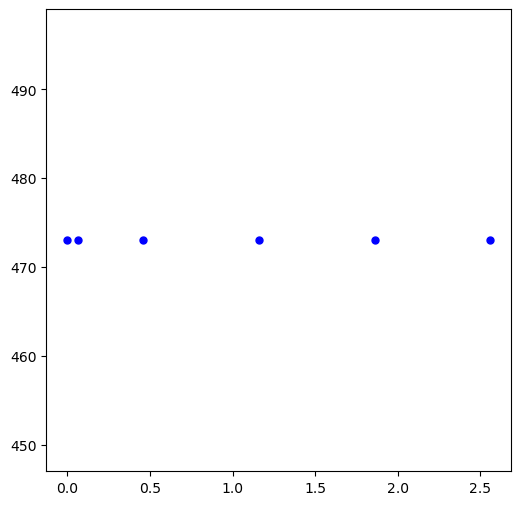

In [60]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4_473K']['Strain'][::70], flows['e4_473K']['Temp'][::70], '.', label='0.0001 /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e4_473K']['Strain'], slstm_train_pred_temp['e4_473K'][:,]+473, label='0.0001 /s Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_473K']['Strain'][::70], flows['e2_473K']['Temp'][::70], '.', label='0.01 /s', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e2_473K']['Strain'], slstm_train_pred_temp['e2_473K'][:,]+473, label='0.01 /s Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_473K']['Strain'][::70], flows['e1_473K']['Temp'][::70], '.', label='0.1 /s', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e1_473K']['Strain'], slstm_train_pred_temp['e1_473K'][:,]+473, label='0.1 /s Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=460, ymax=490) # y-axis range
#plt.title('Initial Temperature 473 K')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

NameError: name 'slstm_train_pred_temp' is not defined

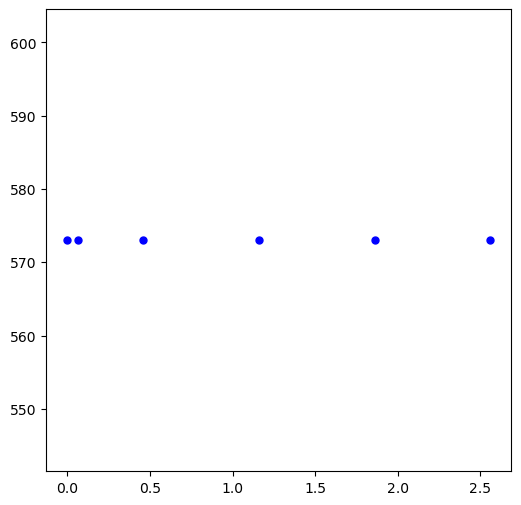

In [61]:
plt.figure(figsize=(6,6))

plt.plot(flows['e3_573K']['Strain'][::70], flows['e3_573K']['Temp'][::70], '.', label='$10^{-3}$ /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e3_573K']['Strain'], slstm_train_pred_temp['e3_573K'][:,]+573, label='$10^{-3}$ /s Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=2,fontsize='12', fancybox=True, framealpha=0.2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=550, ymax=600) # y-axis range

#plt.title('Initial Temperature 573 K', fontsize='20')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

(array([660., 665., 670., 675., 680., 685., 690.]),
 [Text(0, 660.0, '660'),
  Text(0, 665.0, '665'),
  Text(0, 670.0, '670'),
  Text(0, 675.0, '675'),
  Text(0, 680.0, '680'),
  Text(0, 685.0, '685'),
  Text(0, 690.0, '690')])

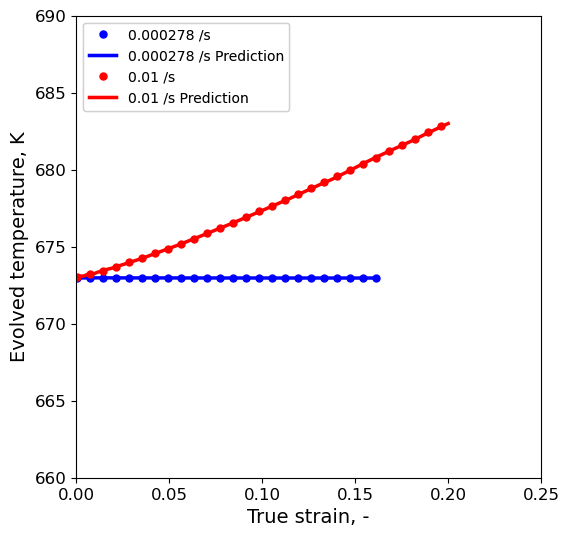

In [76]:
plt.figure(figsize=(6,6))

plt.plot(flows['673K']['Strain'][::70], flows['673K']['Temp'][::70], '.', label='0.000278 /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['673K']['Strain'], slstm_train_pred_temp['673K'][:,]+673, label='0.000278 /s Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_673K']['Strain'][::70], flows['e1_673K']['Temp'][::70], '.', label='0.01 /s', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e1_673K']['Strain'], slstm_train_pred_temp['e1_673K'][:,]+673, label='0.01 /s Prediction', color='red', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=660, ymax=690) # y-axis range
#plt.title('Initial Temperature 673 K')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

### Testing results

In [77]:
slstm_test_pred_stress = {}
slstm_test_pred_temp = {}
for key, X in X_test_dict.items():
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    slstm_test_pred_stress[key] = manual_descaling(best_slstm.predict(X)[:,0], stress_range)
    slstm_test_pred_temp[key] = manual_descaling(best_slstm.predict(X)[:,1], delT_range)

#### Stress predictions

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600')])

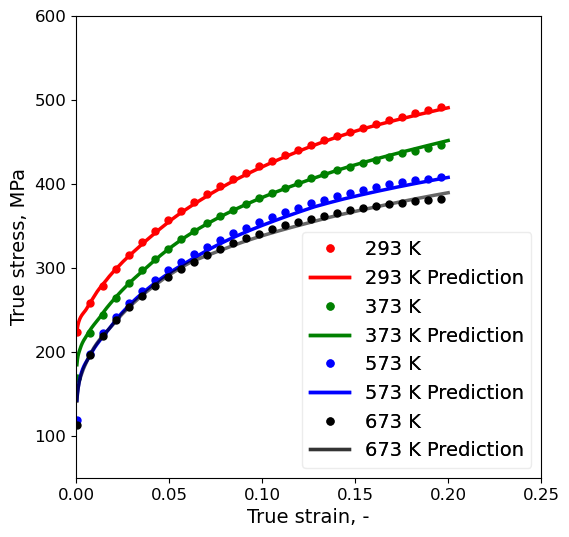

In [78]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4']['Strain'][::70], flows['e4']['Stress'][::70], '.', label='293 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e4']['Strain'], slstm_test_pred_stress['e4'][:,], label='293 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e4_373K']['Strain'][::70], flows['e4_373K']['Stress'][::70], '.', label='373 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e4_373K']['Strain'], slstm_test_pred_stress['e4_373K'][:,], label='373 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e4_573K']['Strain'][::70], flows['e4_573K']['Stress'][::70], '.', label='573 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e4_573K']['Strain'], slstm_test_pred_stress['e4_573K'][:,], label='573 K Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e4_673K']['Strain'][::70], flows['e4_673K']['Stress'][::70], '.', label='673 K', color='black', alpha=1.0, markersize=10)
plt.plot(flows['e4_673K']['Strain'], slstm_test_pred_stress['e4_673K'][:,], label='673 K Prediction', color='black', alpha=0.6, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=4,fontsize='14',framealpha=0.2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=50, ymax=600) # y-axis range
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
#plt.title('Strain rate 0.0001 /s', fontsize='20')

(array([100., 200., 300., 400., 500., 600.]),
 [Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600')])

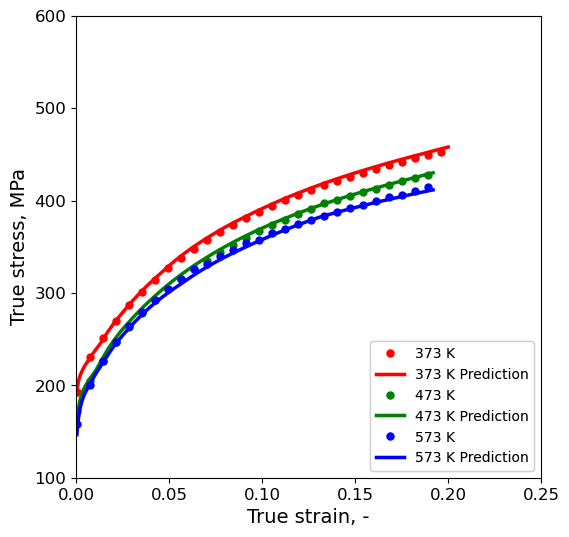

In [79]:
plt.figure(figsize=(6,6))

plt.plot(flows['373K']['Strain'][::70], flows['373K']['Stress'][::70], '.', label='373 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['373K']['Strain'], slstm_test_pred_stress['373K'][:,], label='373 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['473K']['Strain'][::70], flows['473K']['Stress'][::70], '.', label='473 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['473K']['Strain'], slstm_test_pred_stress['473K'][:,], label='473 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['573K']['Strain'][::70], flows['573K']['Stress'][::70], '.', label='573 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['573K']['Strain'], slstm_test_pred_stress['573K'][:,], label='573 K Prediction', color='blue', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=4))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=100, ymax=600) # y-axis range
#plt.title('Strain rate 0.000278 /s')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

(array([100., 200., 300., 400., 500., 600.]),
 [Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600')])

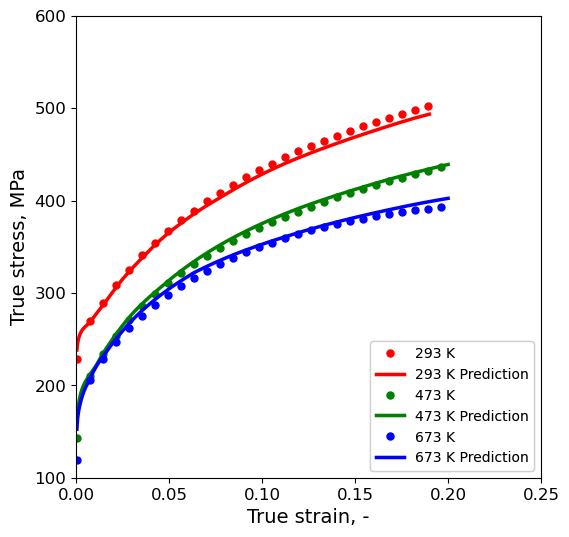

In [80]:
plt.figure(figsize=(6,6))

plt.plot(flows['e3']['Strain'][::70], flows['e3']['Stress'][::70], '.', label='293 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e3']['Strain'], slstm_test_pred_stress['e3'][:,], label='293 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3_473K']['Strain'][::70], flows['e3_473K']['Stress'][::70], '.', label='473 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e3_473K']['Strain'], slstm_test_pred_stress['e3_473K'][:,], label='473 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3_673K']['Strain'][::70], flows['e3_673K']['Stress'][::70], '.', label='673 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e3_673K']['Strain'], slstm_test_pred_stress['e3_673K'][:,], label='673 K Prediction', color='blue', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=4))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=100, ymax=600) # y-axis range
#plt.title('Strain rate 0.001 /s')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

(array([100., 200., 300., 400., 500., 600.]),
 [Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600')])

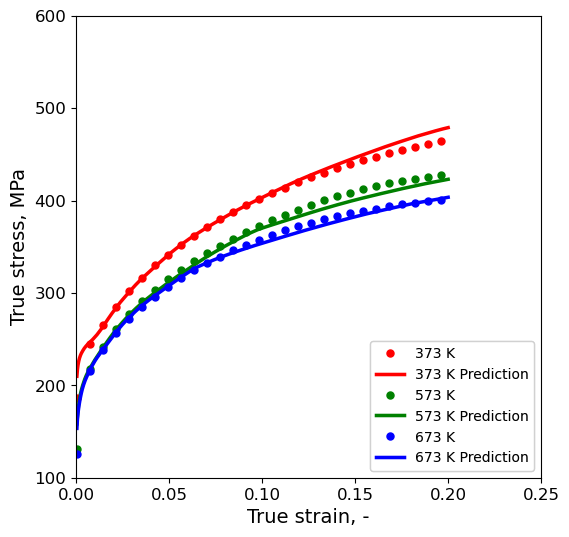

In [81]:
plt.figure(figsize=(6,6))

plt.plot(flows['e2_373K']['Strain'][::70], flows['e2_373K']['Stress'][::70], '.', label='373 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e2_373K']['Strain'], slstm_test_pred_stress['e2_373K'][:,], label='373 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_573K']['Strain'][::70], flows['e2_573K']['Stress'][::70], '.', label='573 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e2_573K']['Strain'], slstm_test_pred_stress['e2_573K'][:,], label='573 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_673K']['Strain'][::70], flows['e2_673K']['Stress'][::70], '.', label='673 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e2_673K']['Strain'], slstm_test_pred_stress['e2_673K'][:,], label='673 K Prediction', color='blue', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=4))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=100, ymax=600) # y-axis range
#plt.title('Strain rate 0.01 /s')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600')])

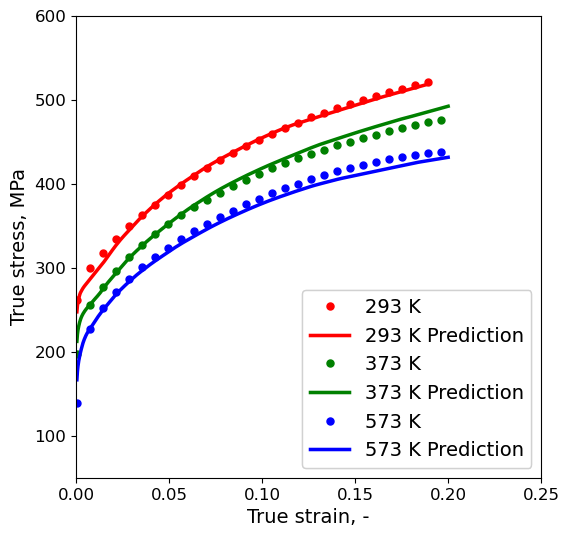

In [82]:
plt.figure(figsize=(6,6))

plt.plot(flows['e1']['Strain'][::70], flows['e1']['Stress'][::70], '.', label='293 K', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e1']['Strain'], slstm_test_pred_stress['e1'][:,], label='293 K Prediction', color='red', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_373K']['Strain'][::70], flows['e1_373K']['Stress'][::70], '.', label='373 K', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e1_373K']['Strain'], slstm_test_pred_stress['e1_373K'][:,], label='373 K Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_573K']['Strain'][::70], flows['e1_573K']['Stress'][::70], '.', label='573 K', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e1_573K']['Strain'], slstm_test_pred_stress['e1_573K'][:,], label='573 K Prediction', color='blue', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=4,fontsize='14'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('True stress, MPa', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=50, ymax=600) # y-axis range

#plt.title('Strain rate 0.1 /s', fontsize='20')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

#### Temperature prediction

(array([292., 294., 296., 298., 300., 302., 304., 306., 308.]),
 [Text(0, 292.0, '292'),
  Text(0, 294.0, '294'),
  Text(0, 296.0, '296'),
  Text(0, 298.0, '298'),
  Text(0, 300.0, '300'),
  Text(0, 302.0, '302'),
  Text(0, 304.0, '304'),
  Text(0, 306.0, '306'),
  Text(0, 308.0, '308')])

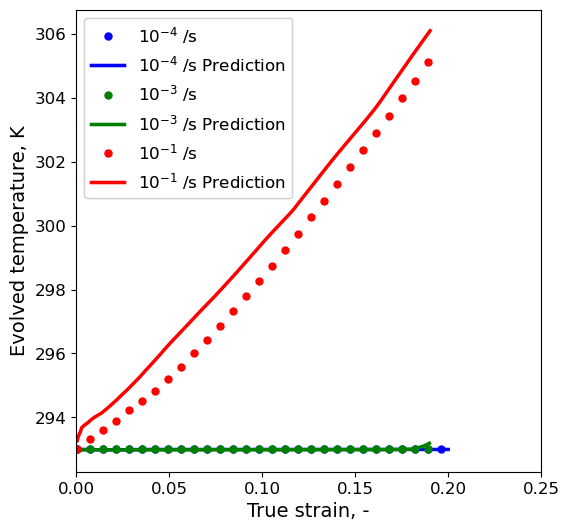

In [83]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4']['Strain'][::70], flows['e4']['Temp'][::70], '.', label='$10^{-4}$ /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e4']['Strain'], slstm_test_pred_temp['e4'][:,]+293, label='$10^{-4}$ /s Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3']['Strain'][::70], flows['e3']['Temp'][::70], '.', label='$10^{-3}$ /s', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e3']['Strain'], slstm_test_pred_temp['e3'][:,]+293, label='$10^{-3}$ /s Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1']['Strain'][::70], flows['e1']['Temp'][::70], '.', label='$10^{-1}$ /s', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e1']['Strain'], slstm_test_pred_temp['e1'][:,]+293, label='$10^{-1}$ /s Prediction', color='red', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=2,fontsize='12'))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
#plt.ylim(ymin=50, ymax=600) # y-axis range

#plt.title('Initial Temperature 293 K', fontsize='20')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

(array([372., 374., 376., 378., 380., 382., 384., 386.]),
 [Text(0, 372.0, '372'),
  Text(0, 374.0, '374'),
  Text(0, 376.0, '376'),
  Text(0, 378.0, '378'),
  Text(0, 380.0, '380'),
  Text(0, 382.0, '382'),
  Text(0, 384.0, '384'),
  Text(0, 386.0, '386')])

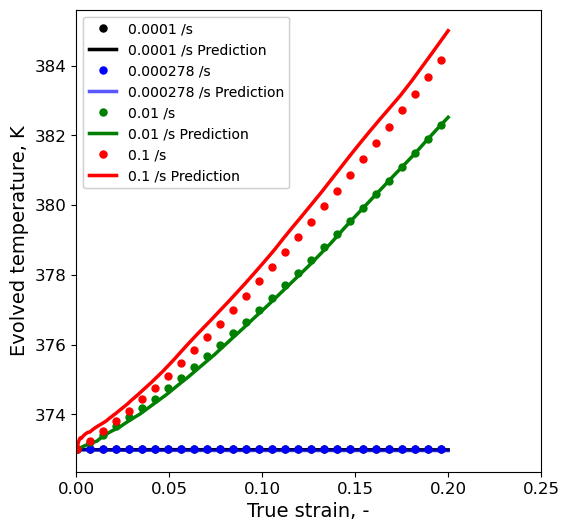

In [84]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4_373K']['Strain'][::70], flows['e4_373K']['Temp'][::70], '.', label='0.0001 /s', color='black', alpha=1.0, markersize=10)
plt.plot(flows['e4_373K']['Strain'], slstm_test_pred_temp['e4_373K'][:,]+373, label='0.0001 /s Prediction', color='black', alpha=1.0, linewidth=2.5)

plt.plot(flows['373K']['Strain'][::70], flows['373K']['Temp'][::70], '.', label='0.000278 /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['373K']['Strain'], slstm_test_pred_temp['373K'][:,]+373, label='0.000278 /s Prediction', color='blue', alpha=0.6, linewidth=2.5)

plt.plot(flows['e2_373K']['Strain'][::70], flows['e2_373K']['Temp'][::70], '.', label='0.01 /s', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e2_373K']['Strain'], slstm_test_pred_temp['e2_373K'][:,]+373, label='0.01 /s Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_373K']['Strain'][::70], flows['e1_373K']['Temp'][::70], '.', label='0.1 /s', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e1_373K']['Strain'], slstm_test_pred_temp['e1_373K'][:,]+373, label='0.1 /s Prediction', color='red', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
#plt.ylim(ymin=100, ymax=600) # y-axis range
#plt.title('Initial Temperature 373 K')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

(array([400., 420., 440., 460., 480., 500., 520., 540., 560.]),
 [Text(0, 400.0, '400'),
  Text(0, 420.0, '420'),
  Text(0, 440.0, '440'),
  Text(0, 460.0, '460'),
  Text(0, 480.0, '480'),
  Text(0, 500.0, '500'),
  Text(0, 520.0, '520'),
  Text(0, 540.0, '540'),
  Text(0, 560.0, '560')])

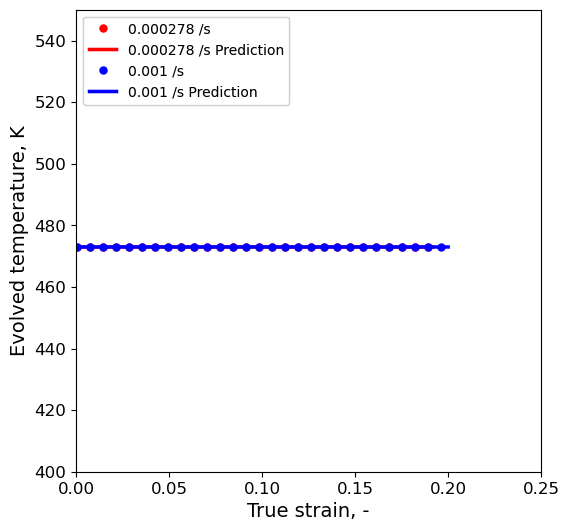

In [85]:
plt.figure(figsize=(6,6))

plt.plot(flows['473K']['Strain'][::70], flows['473K']['Temp'][::70], '.', label='0.000278 /s', color='red', alpha=1.0, markersize=10)
plt.plot(flows['473K']['Strain'], slstm_test_pred_temp['473K'][:,]+473, label='0.000278 /s Prediction', color='red', alpha=1.0, linewidth=2.5)


plt.plot(flows['e3_473K']['Strain'][::70], flows['e3_473K']['Temp'][::70], '.', label='0.001 /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e3_473K']['Strain'], slstm_test_pred_temp['e3_473K'][:,]+473, label='0.001 /s Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.gca().add_artist(plt.legend(loc=2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
plt.ylim(ymin=400, ymax=550) # y-axis range
#plt.title('Initial Temperature 473 K')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')

(array([572., 574., 576., 578., 580., 582., 584.]),
 [Text(0, 572.0, '572'),
  Text(0, 574.0, '574'),
  Text(0, 576.0, '576'),
  Text(0, 578.0, '578'),
  Text(0, 580.0, '580'),
  Text(0, 582.0, '582'),
  Text(0, 584.0, '584')])

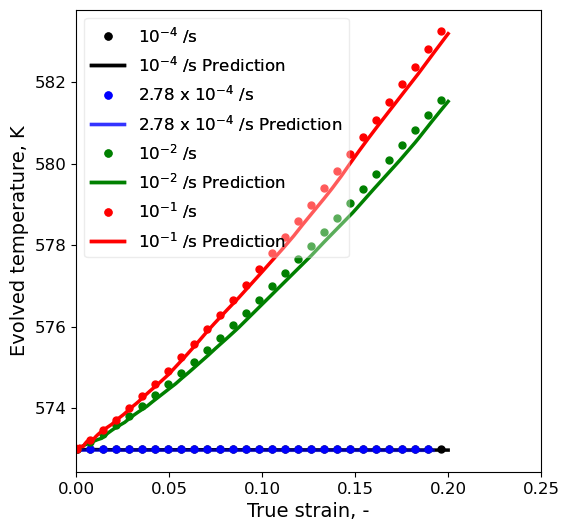

In [86]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4_573K']['Strain'][::70], flows['e4_573K']['Temp'][::70], '.', label='$10^{-4}$ /s', color='black', alpha=1.0, markersize=10)
plt.plot(flows['e4_573K']['Strain'], slstm_test_pred_temp['e4_573K'][:,]+573, label='$10^{-4}$ /s Prediction', color='black', alpha=1.0, linewidth=2.5)

plt.plot(flows['573K']['Strain'][::70], flows['573K']['Temp'][::70], '.', label='2.78 x $10^{-4}$ /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['573K']['Strain'], slstm_test_pred_temp['573K'][:,]+573, label='2.78 x $10^{-4}$ /s Prediction', color='blue', alpha=0.6, linewidth=2.5)

plt.plot(flows['e2_573K']['Strain'][::70], flows['e2_573K']['Temp'][::70], '.', label='$10^{-2}$ /s', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e2_573K']['Strain'], slstm_test_pred_temp['e2_573K'][:,]+573, label='$10^{-2}$ /s Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e1_573K']['Strain'][::70], flows['e1_573K']['Temp'][::70], '.', label='$10^{-1}$ /s', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e1_573K']['Strain'], slstm_test_pred_temp['e1_573K'][:,]+573, label='$10^{-1}$ /s Prediction', color='red', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=2,fontsize='12', fancybox=True, framealpha=0.2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
#plt.ylim(ymin=50, ymax=600) # y-axis range
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')
#plt.title('Initial Temperature 573 K', fontsize='20')

(array([672., 674., 676., 678., 680., 682.]),
 [Text(0, 672.0, '672'),
  Text(0, 674.0, '674'),
  Text(0, 676.0, '676'),
  Text(0, 678.0, '678'),
  Text(0, 680.0, '680'),
  Text(0, 682.0, '682')])

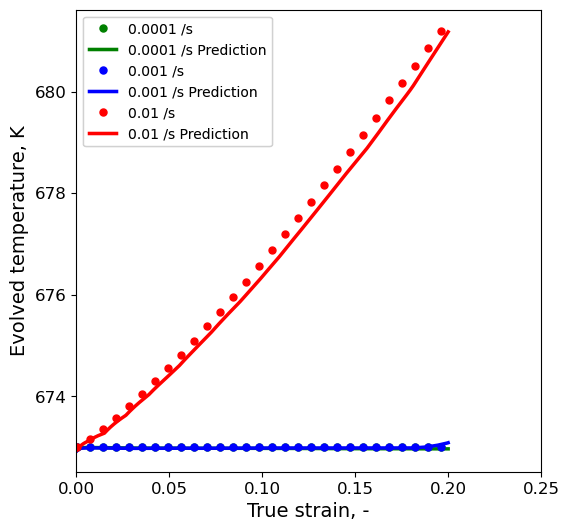

In [87]:
plt.figure(figsize=(6,6))

plt.plot(flows['e4_673K']['Strain'][::70], flows['e4_673K']['Temp'][::70], '.', label='0.0001 /s', color='green', alpha=1.0, markersize=10)
plt.plot(flows['e4_673K']['Strain'], slstm_test_pred_temp['e4_673K'][:,]+673, label='0.0001 /s Prediction', color='green', alpha=1.0, linewidth=2.5)

plt.plot(flows['e3_673K']['Strain'][::70], flows['e3_673K']['Temp'][::70], '.', label='0.001 /s', color='blue', alpha=1.0, markersize=10)
plt.plot(flows['e3_673K']['Strain'], slstm_test_pred_temp['e3_673K'][:,]+673, label='0.001 /s Prediction', color='blue', alpha=1.0, linewidth=2.5)

plt.plot(flows['e2_673K']['Strain'][::70], flows['e2_673K']['Temp'][::70], '.', label='0.01 /s', color='red', alpha=1.0, markersize=10)
plt.plot(flows['e2_673K']['Strain'], slstm_test_pred_temp['e2_673K'][:,]+673, label='0.01 /s Prediction', color='red', alpha=1.0, linewidth=2.5)


plt.gca().add_artist(plt.legend(loc=2))
plt.xlabel('True strain, -', fontsize='14')    #Name x label
plt.ylabel('Evolved temperature, K', fontsize='14')    #Name y label
plt.xlim(xmin=0, xmax=0.25) # x-axis range
#plt.xticks(np.linspace(0,0.2,5)) # x-axis range
#plt.ylim(ymin=100, ymax=600) # y-axis range
#plt.title('Initial Temperature 673 K')
plt.xticks(fontsize='12')
plt.yticks(fontsize='12')